info at 
- https://www.kaggle.com/datasets/openfoodfacts/world-food-facts
- https://nutriscore.impag.chhttps://nutriscore.impag.ch

# Imports

In [4]:
import io
import shutil
import glob
import requests
from zipfile import ZipFile
from tempfile import mkdtemp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set()

### fonctions

In [5]:
# Chargement du dataset csv depuis un zip en ligne
def load(url: str) -> pd.DataFrame:
    # Request zip on AWS
    print(f'load data from {url}')
    response = requests.get(url)

    # Unzip file
    tempDir = mkdtemp()
    print(f'extract to temp dir: {tempDir}')

    with ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
        zip_ref.extractall(tempDir)

    csv = glob.glob(tempDir + '\*.csv')[0]

    # Read it in pandas
    print('Read csv by pandas')
    df = pd.read_csv(csv, delimiter='\t',
                     parse_dates=True,
                     low_memory=False)

    # Delete temp directory
    print('Delete temp Dir')
    shutil.rmtree(tempDir, ignore_errors=True)

    print('Dataset ready to explore')
    return df

# Affichage des infos du dataset
def infos(df: pd.DataFrame):
    memory_gb = np.round(df.memory_usage(deep=True).sum()/(1024**3),2)
    nb_lignes = df.shape[0]
    nb_columns = df.shape[1]
    print(f'A ce stade le dataset contient {nb_lignes} lignes et {nb_columns} colonnes. (conso mémoire {memory_gb}Gb)')
    
# Graphe des taux de remplissage
def remplissage(df: pd.DataFrame):
    df_na = pd.DataFrame(((1- df.isna().mean()) * 100).round(0)).rename(columns={0: 'mean'})
    ax = sns.barplot(data=df_na, x='mean', y=df_na.index, palette='ocean', order=df_na.sort_values(by='mean', ascending=False).index)
    ax.bar_label(ax.containers[0], fmt='%.0f%%', padding=-25, c="white")
    plt.title('Taux de remplissage des colonnes')


# Extraction d'une serie depuis un champ contenant une liste
def extract_serie(dataFrame: pd.DataFrame, column: str) -> pd.Series:
    words = pd.Series(dtype=np.int32)
    for value in dataFrame.loc[:, column].dropna():
        if type(value) == str:
            splitted_values = value.split(',')
            for splitted_value in splitted_values:
                if splitted_value in words.keys():
                    words[splitted_value] += 1
                else:
                    words[splitted_value] = 0
    
    return words.sort_values(ascending=False)        

# Scaler de données
def scale(values: np.ndarray) -> np.ndarray:
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(values)
    pd.DataFrame(scaled_values).describe().round(2)
    return scaled_values

# Acp
def acp(scaled_values: np.ndarray, n_components = 2) -> {'pca': PCA, 'X_proj': np.ndarray}:
    pca = PCA(n_components=n_components)
    pca.fit(scaled_values)
    return {'pca': pca, 'X_proj': pca.transform(scaled_values)}

# Affichage de 'éboulie des valeurs propres
def acp_eboulis(pca: PCA):
    scree = (pca.explained_variance_ratio_*100).round(2)
    scree_cum = scree.cumsum()
    x = range(1, len(scree)+1)
    plt.bar(height=scree, x=x)
    plt.plot(x, scree_cum, '-o', c='r')
    
    
# Cercle des correlations
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)
    

# Affichage des point projetés de l'acp
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            try:
                plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center', family=['DejaVu Sans', 'Segoe UI'],)
            except:
                print("An exception occurred")

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()



# Lecture et apperçu du dataset

In [6]:
url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip'    
df = load(url)
df_original = df.copy()

load data from https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip
extract to temp dir: C:\Users\gagno\AppData\Local\Temp\tmp068nsgaj
Read csv by pandas
Delete temp Dir
Dataset ready to explore


In [7]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
infos(df)

A ce stade le dataset contient 320772 lignes et 162 colonnes. (conso mémoire 1.72Gb)


# Idée d'application

L'idée de l'application serait de savoir si il existe un produit soit de même nom, soit de la même catégorie, qui respecte mieux la repartition energetique Proteins(13%)/Lipides(37%)/Glucides(50%) (https://www.nutrisens.com/vitalites/comment-decrypter-les-valeurs-nutritionnelles/)

Hypothèses à vérifier dans ce dataset:

1. On peut extraire le nom et la liste des catégories dans lequel est déclaré le produit
2. L'energie est correlée aux proteines, lipides, glucides et eventuellement au nutriscore/nutrigrade
3. On va pouvoir extrapoler les données manquantes d'une des composantes en connaissant les autres
4. On peut deduire d'une ACP que l'energy est une composante principale composée des proteines, lipides glucides


## Filtrage des colonnes necessaires à l'étude

In [9]:
df = df.loc[:, ['product_name','energy_100g', 'proteins_100g', 'carbohydrates_100g', 'fat_100g', 'nutrition-score-fr_100g', 'nutrition_grade_fr', 'fiber_100g', 'categories_fr']]

In [10]:
df.describe()

,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,nutrition-score-fr_100g,fiber_100g
count,2.611130e+05,259922.000000,243588.000000,243891.000000,221210.000000,200886.000000
mean,1.141915e+03,7.075940,32.073981,12.730379,9.165535,2.862111
std,6.447154e+03,8.409054,29.731719,17.578747,9.055903,12.867578
min,0.000000e+00,-800.000000,0.000000,0.000000,-15.000000,-6.700000
25%,3.770000e+02,0.700000,6.000000,0.000000,1.000000,0.000000
50%,1.100000e+03,4.760000,20.600000,5.000000,10.000000,1.500000
75%,1.674000e+03,10.000000,58.330000,20.000000,16.000000,3.600000
max,3.251373e+06,430.000000,2916.670000,714.290000,40.000000,5380.000000


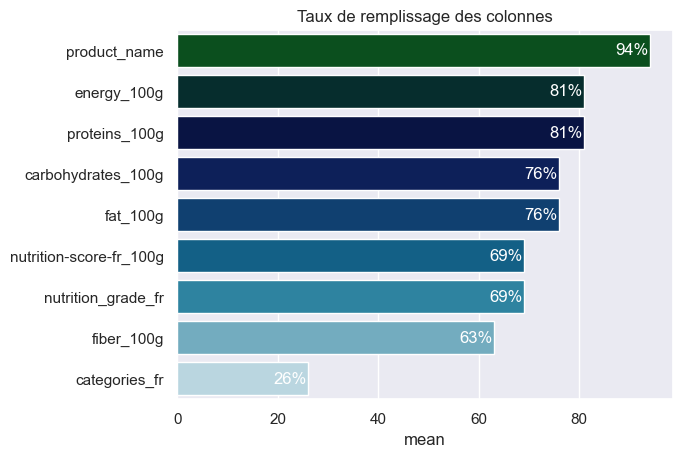

In [11]:
remplissage(df)

## Nettoyage

### Suppressions des valeurs abérantes

In [12]:
df.loc[df['proteins_100g'] < 0, 'proteins_100g'] = np.nan
df.loc[df['carbohydrates_100g'] < 0, 'carbohydrates_100g'] = np.nan
df.loc[df['fat_100g'] < 0, 'fat_100g'] = np.nan

df.loc[df['proteins_100g'] > 100, 'proteins_100g'] = np.nan
df.loc[df['carbohydrates_100g'] > 100, 'carbohydrates_100g'] = np.nan
df.loc[df['fat_100g'] > 100, 'fat_100g'] = np.nan

### Suppression des lignes vides

In [13]:
nb_lignes_vides = df.loc[df.isna().sum(axis=1) == df.shape[1], :]
print(f'Suppression des {len(nb_lignes_vides)} lignes vides')
df = df.loc[df.isna().sum(axis=1) != df.shape[1], :]
infos(df)

Suppression des 13772 lignes vides
A ce stade le dataset contient 307000 lignes et 9 colonnes. (conso mémoire 0.08Gb)


### Extaction d'un subset permettant l'imputation de valeurs manquantes par regression lineaire

L'energie étant proportionnelle aux proteines, carbohydrates et graisses, on devrait pouvoir deduire les valeurs de chacunes d'elle en fonction de l'energie déclarée

Pour consolider cette hypothese, on va recalculer une energie théorique et extraire un subset qui suit les règles suivantes:
- au moins une donnée parmis protein/sucre/graisse est présente et inclue dans les quantiles 0.25/0.75
- L'energie déclarée est comprise entre 0 et 3800 pour 100g (3800Kcal etant le maximum théorique possible)
- L'energie déclarée est à +- 0.5% de l'energie recalculée

visualisation des qantiles

<Axes: >

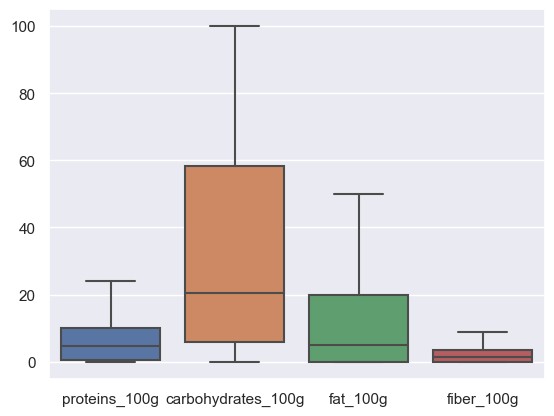

In [14]:
sns.boxplot(data = df.loc[:, ['proteins_100g', 'carbohydrates_100g', 'fat_100g', 'fiber_100g']], showfliers=False)

Extraction du subset suivant les règles énoncées

In [15]:
sample = df.drop('categories_fr', axis=1).dropna()

proteins = sample['proteins_100g']
proteins_inliers = proteins.between(proteins.quantile(0.25), proteins.quantile(0.75))

carbohydrates = sample['carbohydrates_100g']
carbohydrates_inliers = carbohydrates.between(carbohydrates.quantile(0.25), carbohydrates.quantile(0.75))

fat = sample['fat_100g']
fat_inliers = fat.between(fat.quantile(0.25), fat.quantile(0.75))

sample['calc_energy'] = sample['proteins_100g'] * 17 + sample['fat_100g'] * 38 + sample['carbohydrates_100g'] * 17

cond1 = (sample['proteins_100g'] > 0) | (sample['carbohydrates_100g'] > 0) | (sample['fat_100g'] > 0)
cond2 = (sample['energy_100g'] >= 0) & (sample['energy_100g'] <= 3800)
cond3 = proteins_inliers & carbohydrates_inliers & fat_inliers
cond4 = sample['energy_100g'].between(sample['calc_energy']*0.995, sample['calc_energy']*1.005)
sample = sample.loc[cond1 & cond2 & cond3 & cond4, :]
sample.head()

,product_name,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,nutrition-score-fr_100g,nutrition_grade_fr,fiber_100g,calc_energy
195,Butter Croissants,1523.0,7.79,44.16,16.88,18.0,d,1.3,1524.59
216,La Brea Bakery Ciabatta Loaf Freshly Baked In ...,1176.0,8.77,52.63,3.51,3.0,c,1.8,1177.18
279,Cakes Raisins,1768.0,5.80,56.00,19.00,13.0,d,1.8,1772.60
283,Cakes aux Fruits,1670.0,4.90,60.00,15.00,12.0,d,1.5,1673.30
1522,Pumpkin Bars,1523.0,3.03,53.03,15.15,18.0,d,1.5,1528.72


In [16]:
sample.shape

(4025, 9)

### Visualisation des corrélations des données du subset

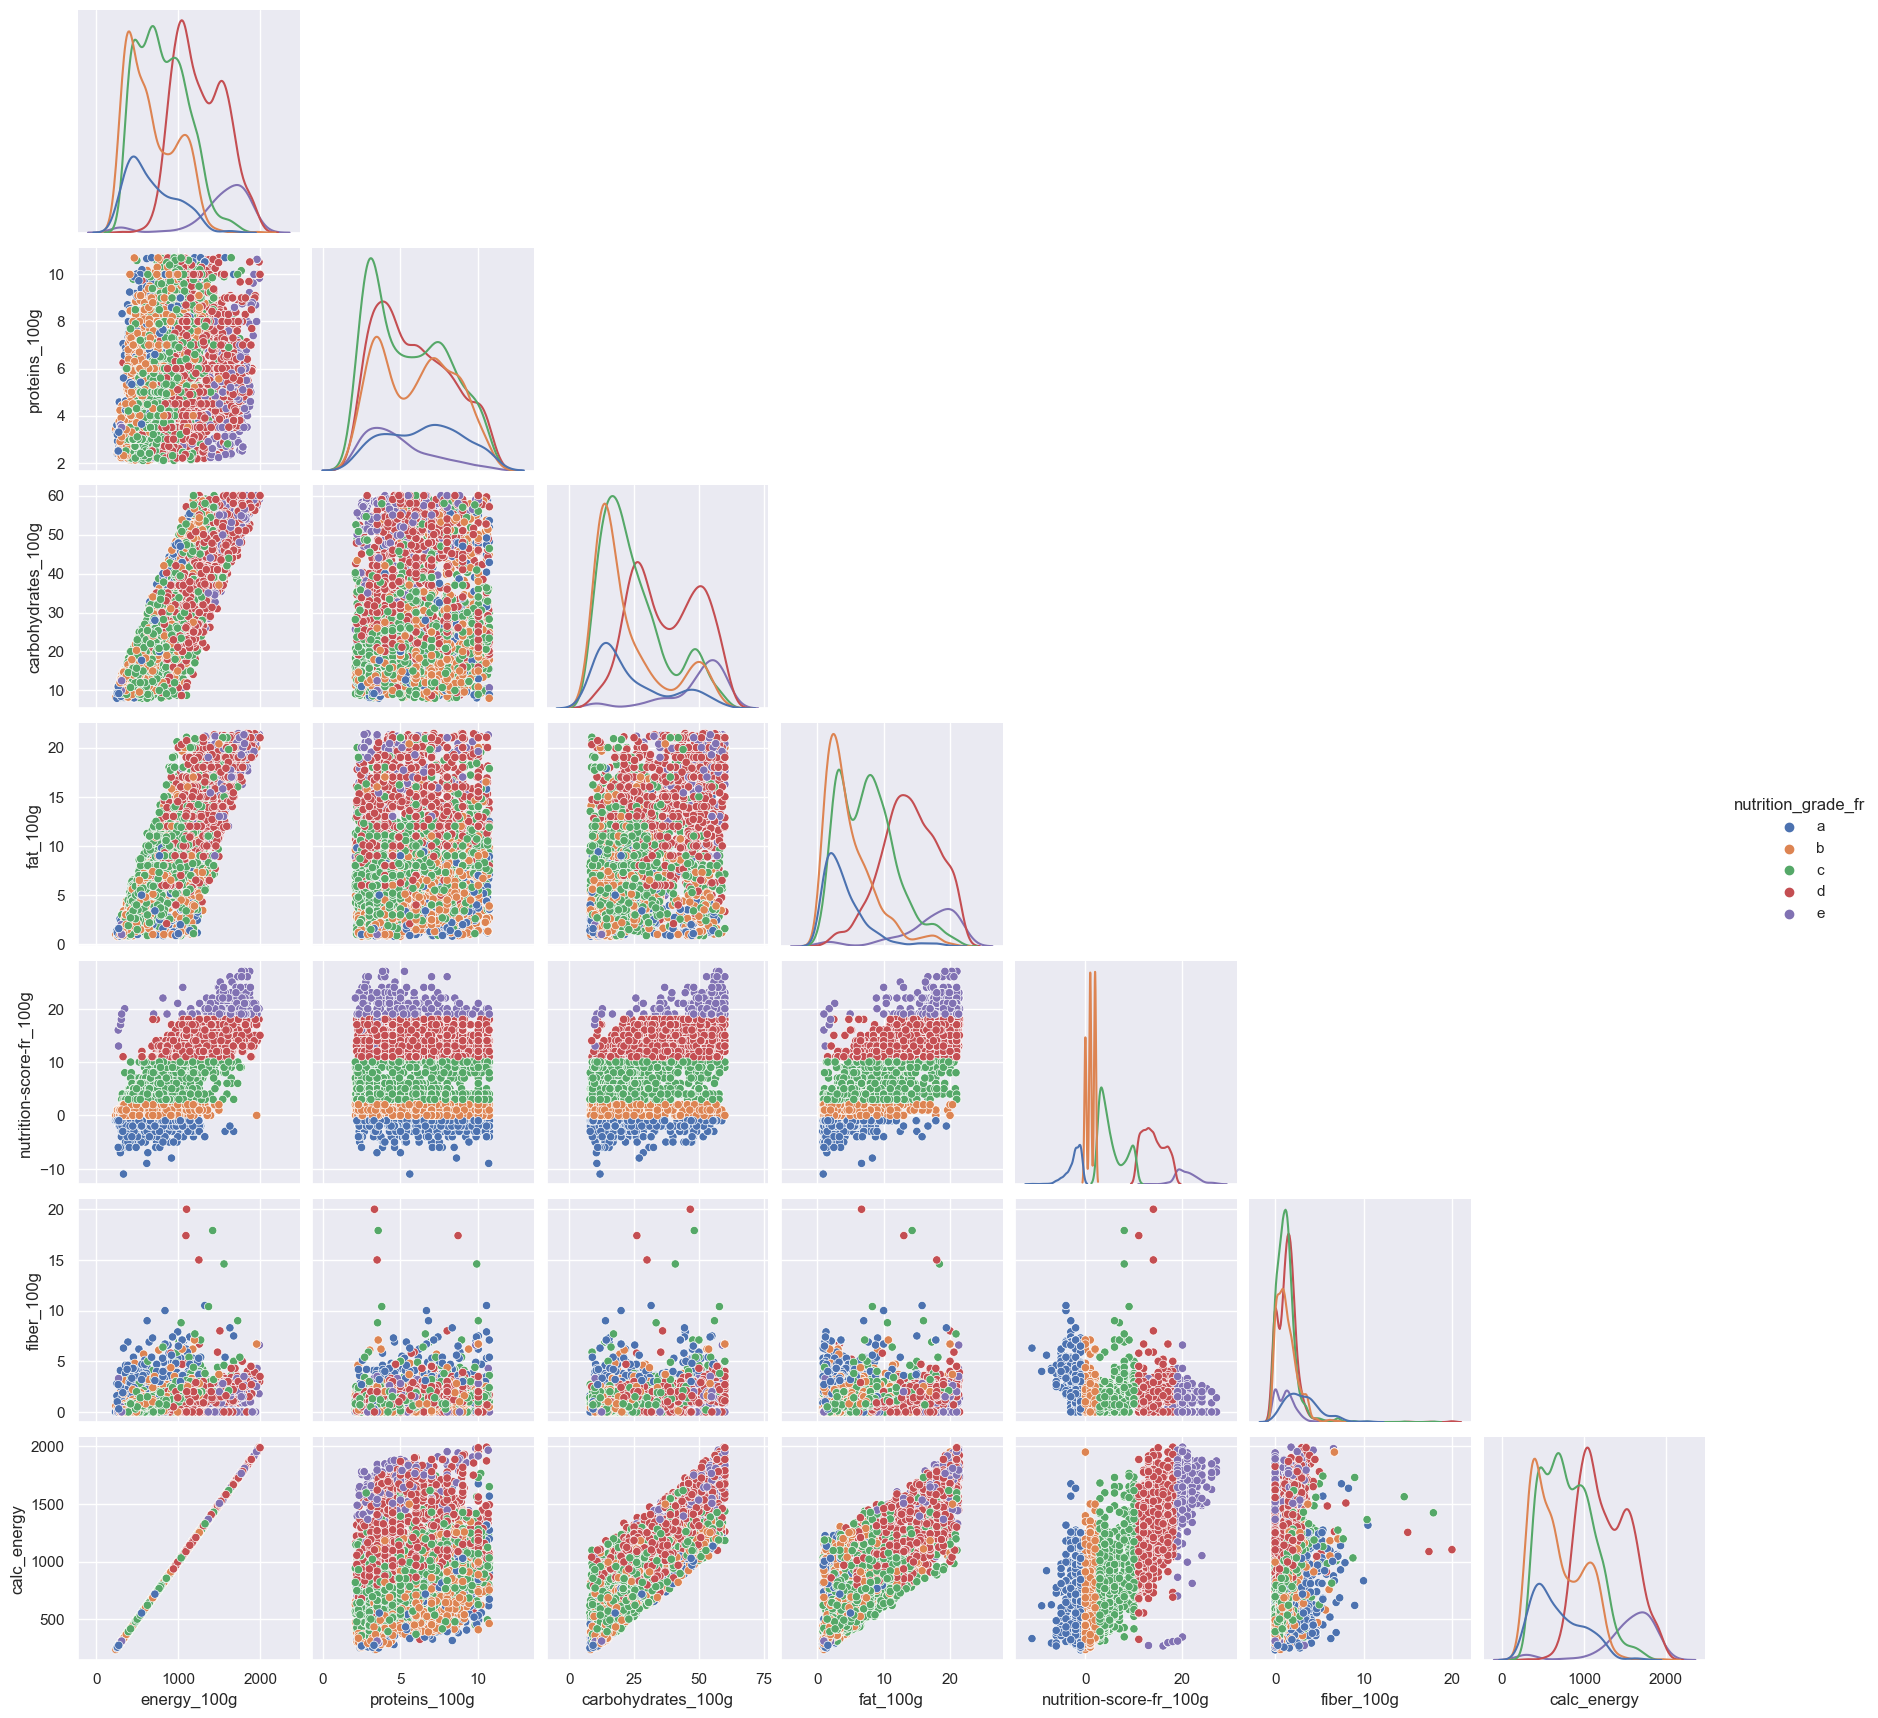

In [17]:
sns.pairplot(sample, hue='nutrition_grade_fr', hue_order=['a', 'b', 'c', 'd', 'e'], corner=True,  diag_kws=dict(fill=False))

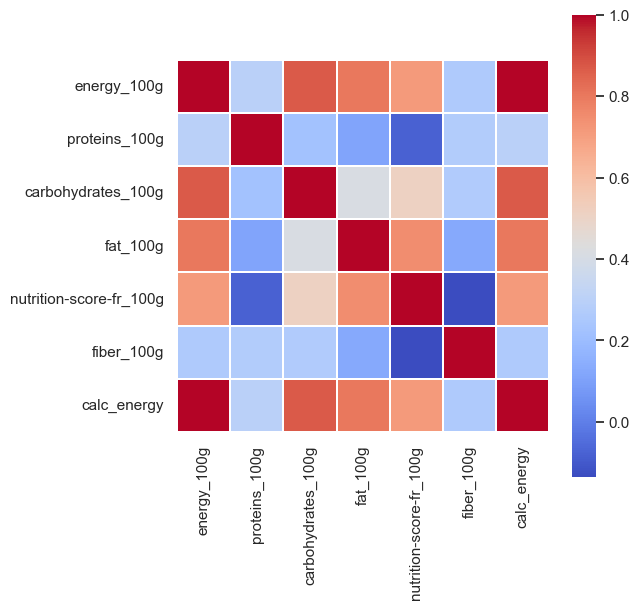

In [18]:
correlations = sample.corr(numeric_only=True)
figure = plt.figure(figsize=(6,6))
sns.heatmap(correlations, square=True, linewidths=0.01, cmap="coolwarm")
plt.show()

### Constat

Malgré une amplitude importante, l'energie a une correlation lineaire avec la graisse et le carbohydrate.
On va utiliser ces corrélations pour remplir les valeurs manquantes lorsque l'energie est déclarée.

Le nutriscore est bien correlé au nutrigrade

### Imputation des graisses par regression linéaire entre graisse et energie

In [19]:
regr = linear_model.LinearRegression()
regr.fit(np.array(sample['fat_100g'].to_list()).reshape(-1, 1), np.array(sample['energy_100g'].to_list()).reshape(-1, 1))

LinearRegression()

In [20]:
score = regr.score(np.array(sample['fat_100g'].to_list()).reshape(-1, 1), np.array(sample['energy_100g'].to_list()).reshape(-1, 1))
score = (score * 100).round(1)

<function matplotlib.pyplot.show(close=None, block=None)>

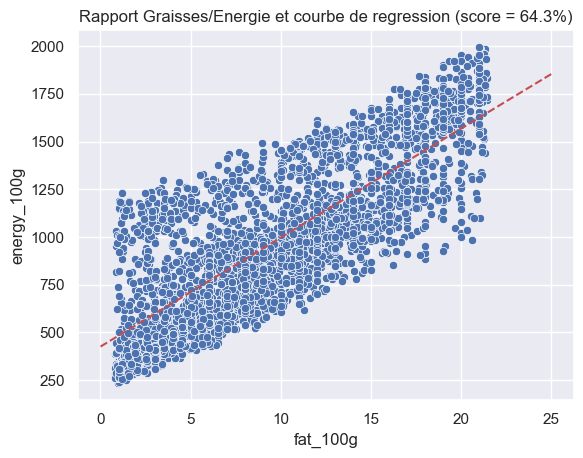

In [21]:
sns.scatterplot(data=sample, x='fat_100g', y='energy_100g')
plt.plot([0, 25], [regr.intercept_, regr.intercept_ + regr.coef_[0] * 25], '--', c='r')
plt.title(f'Rapport Graisses/Energie et courbe de regression (score = {score}%)')
plt.show

Le score de 64.7% n'est pas des meilleurs, mais je décide de garder cette méthode d'imputation

In [22]:
fat_na = df['fat_100g'].isna() & ~df['energy_100g'].isna()
energy = df.loc[fat_na, 'energy_100g']
fat = np.clip((energy - regr.intercept_) / regr.coef_[0], 0, 100)
df.loc[fat_na, 'fat_100g'] = fat

### Imputation des carbohydrates par regression linéaire entre carbohydrates et energie

In [23]:
regr2 = linear_model.LinearRegression()
regr2.fit(np.array(sample['carbohydrates_100g'].to_list()).reshape(-1, 1), np.array(sample['energy_100g'].to_list()).reshape(-1, 1))

LinearRegression()

In [24]:
score = regr2.score(np.array(sample['carbohydrates_100g'].to_list()).reshape(-1, 1), np.array(sample['energy_100g'].to_list()).reshape(-1, 1))
score = (score * 100).round(1)

<function matplotlib.pyplot.show(close=None, block=None)>

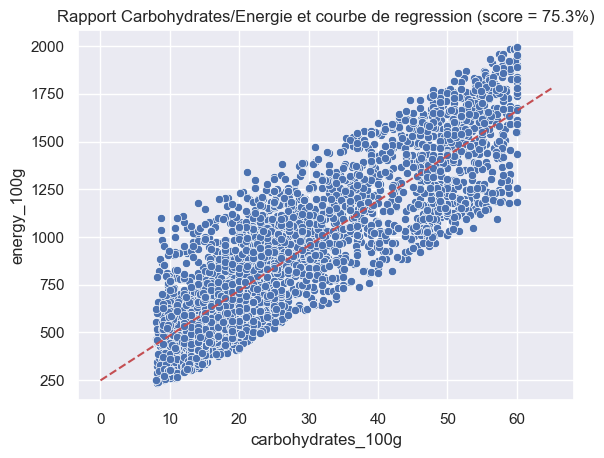

In [25]:
sns.scatterplot(data=sample, x='carbohydrates_100g', y='energy_100g')
plt.plot([0, 65], [regr2.intercept_, regr2.intercept_ + regr2.coef_[0] * 65], '--', c='r')
plt.title(f'Rapport Carbohydrates/Energie et courbe de regression (score = {score}%)')
plt.show

Le score de 75.3% est meilleur que pour les graisses.

Imputation si valeur energie présente:

In [26]:
ch_na = df['carbohydrates_100g'].isna() & ~df['energy_100g'].isna()
energy = df.loc[ch_na, 'energy_100g']
ch = np.clip((energy - regr2.intercept_) / regr2.coef_[0], 0, 100)
df.loc[ch_na, 'carbohydrates_100g'] = ch

### Bilan intermédiaire du taux de remplissage

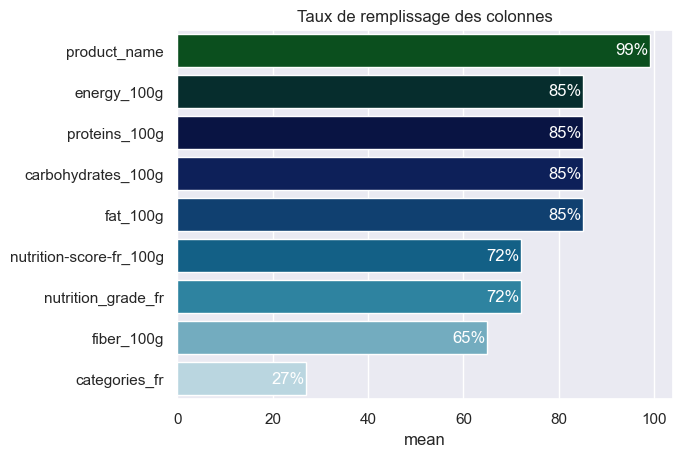

In [27]:
remplissage(df)

### Imputation des valeurs numériques manquantes restantes par KNNImputer

Je décide d'imputer les valeurs restantes grâce à un KNN imputer

In [28]:
from sklearn.impute import KNNImputer
numeric_cols = df.select_dtypes('number').columns
X = df.loc[:, numeric_cols].values
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
df[numeric_cols] = pd.DataFrame(X_imputed, columns=numeric_cols, index=df.index)[numeric_cols]

Vérifications si des valeurs abérantes ont été imputées par le KNN

<Axes: >

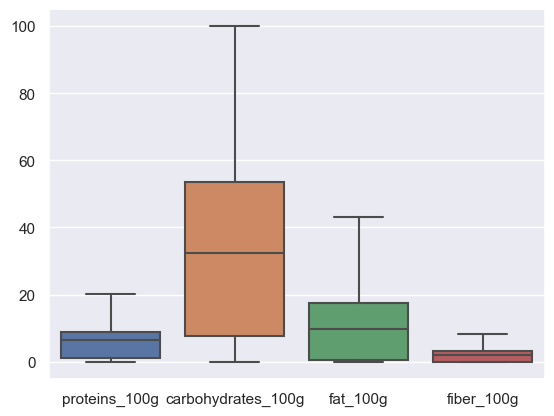

In [29]:
sns.boxplot(data = df.loc[:, ['proteins_100g', 'carbohydrates_100g', 'fat_100g', 'fiber_100g']], showfliers=False)

### affectation des nutrigrades manquants

In [30]:
df.loc[df['nutrition_grade_fr'].isna() & (df['nutrition-score-fr_100g'] < 0), 'nutrition_grade_fr'] = 'a'
df.loc[df['nutrition_grade_fr'].isna() & (df['nutrition-score-fr_100g'] >= 0) & (df['nutrition-score-fr_100g'] <= 2), 'nutrition_grade_fr'] = 'b'
df.loc[df['nutrition_grade_fr'].isna() & (df['nutrition-score-fr_100g'] > 2) & (df['nutrition-score-fr_100g'] <= 10), 'nutrition_grade_fr'] = 'c'
df.loc[df['nutrition_grade_fr'].isna() & (df['nutrition-score-fr_100g'] > 10) & (df['nutrition-score-fr_100g'] <= 18), 'nutrition_grade_fr'] = 'd'
df.loc[df['nutrition_grade_fr'].isna() & (df['nutrition-score-fr_100g'] > 18), 'nutrition_grade_fr'] = 'e'

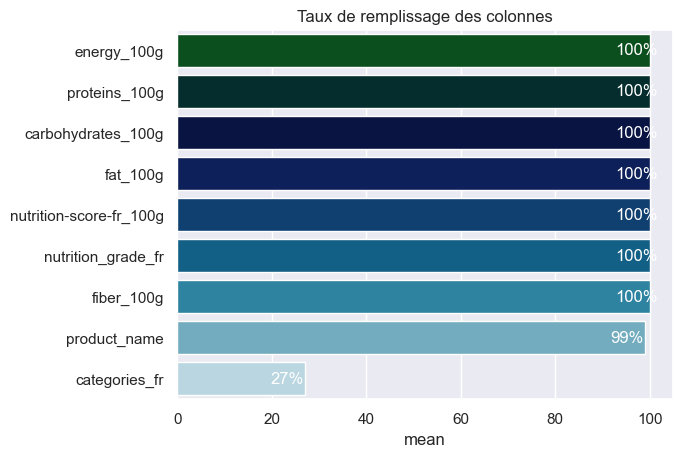

In [31]:
remplissage(df)

Fin du nettoyage des données

## Analyse des categories

In [32]:
df.loc[:, 'categories_fr'].dropna().unique()[:10]

array(['Filet-de-boeuf',
       "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Frais,Aliments à base de fruits et de légumes,Aliments à base de plantes frais,Légumes et dérivés,Légumes frais,Légumes-feuilles",
       'Snacks sucrés,Biscuits et gâteaux,Pâtisseries',
       "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Céréales et pommes de terre,Pains",
       'Boulange',
       "Aliments et boissons à base de végétaux,Aliments d'origine végétale,Céréales et pommes de terre,Légumineuses et dérivés,Légumineuses,Graines,Graines de légumineuses,Légumes secs,Lentilles,Lentilles vertes",
       'Root-bier', 'Snacks sucrés,Biscuits et gâteaux,Biscuits,Sablés',
       'Plats préparés,Pizzas tartes salées et quiches,Quiches,Quiches lorraines',
       'Viandes,Volailles,Poulets,Poulets cuisinés'], dtype=object)

Certaine valeurs apparaissent plusieurs fois, je crée et utilise une fonction generique qui renverra une serie basée sur une colonne avec leur nombre d'apparitions

Text(0.5, 1.0, 'Nombre de produits par catégorie')

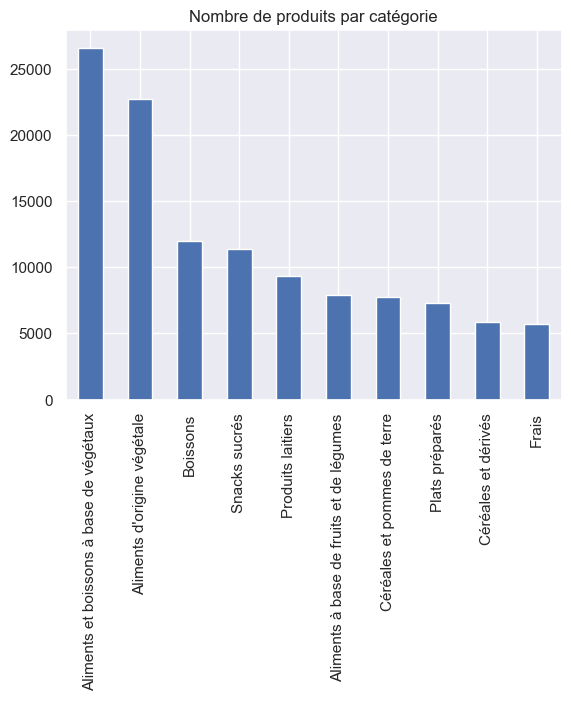

In [33]:
extract_serie(df, 'categories_fr')[0:10].plot.bar()
plt.title('Nombre de produits par catégorie')

on peut donc imaginer extraire les catégories et proceder à des comparaisons dans la future application

## ANOVA

<Axes: xlabel='proteins_100g', ylabel='nutrition_grade_fr'>

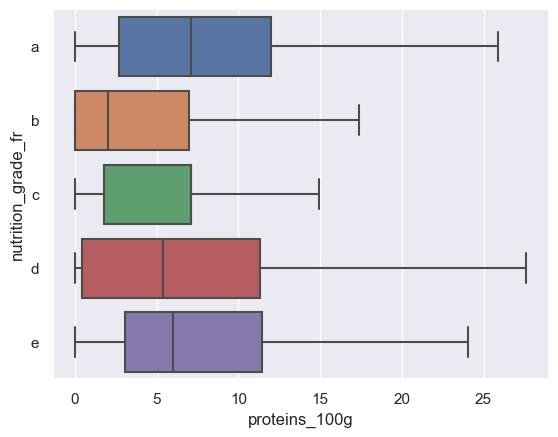

In [41]:
sns.boxplot(data=df, x='proteins_100g', y='nutrition_grade_fr', orient='h', order=['a','b','c','d','e'], showfliers=False)

## PCA

In [31]:
values = df[numeric_cols].values
scaled_values = scale(values)

In [32]:
scaled_df = pd.DataFrame(scaled_values)
scaled_df.describe().round(2).loc[['mean', 'std'], :]

,0,1,2,3,4,5
mean,-0.0,-0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


In [33]:
result = acp(scaled_values=scaled_values, n_components=6)

In [34]:
result['pca'].explained_variance_ratio_

array([0.28788619, 0.19702147, 0.169443  , 0.15358266, 0.13344915,
       0.05861754])

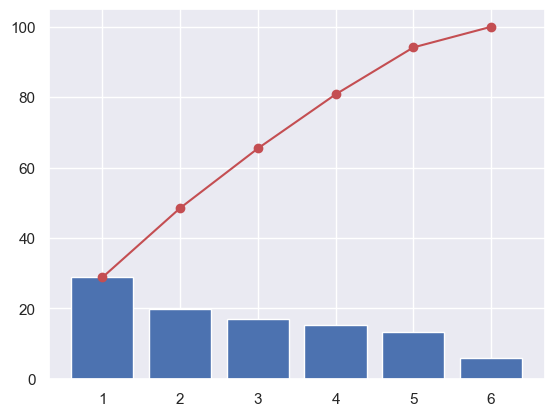

In [35]:
acp_eboulis(pca=result['pca'])

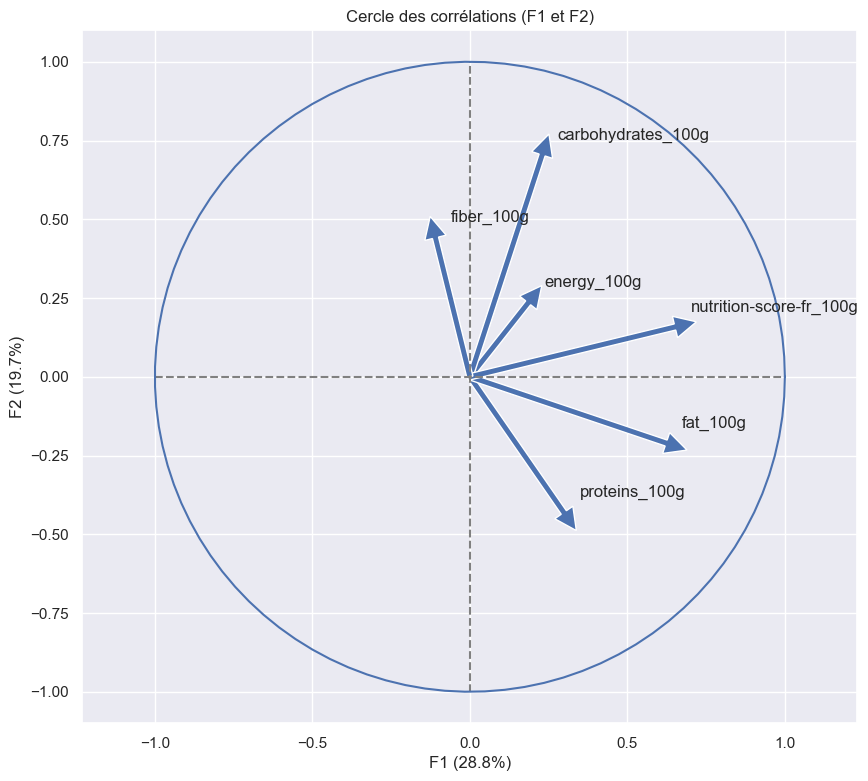

In [38]:
correlation_graph(result['pca'], (0,1), numeric_cols)

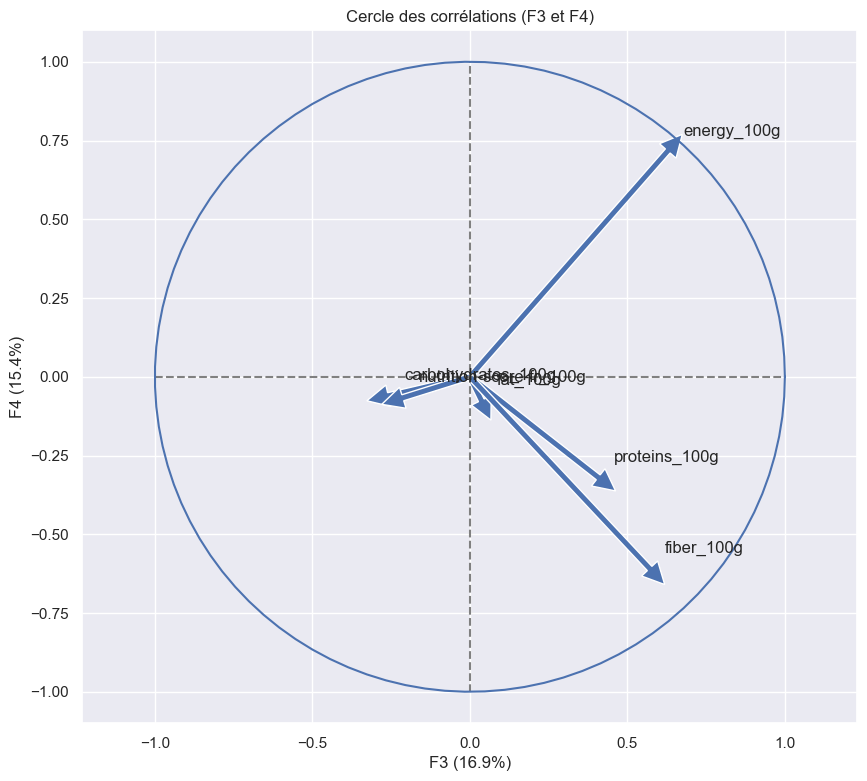

In [39]:
correlation_graph(result['pca'], (2,3), numeric_cols)

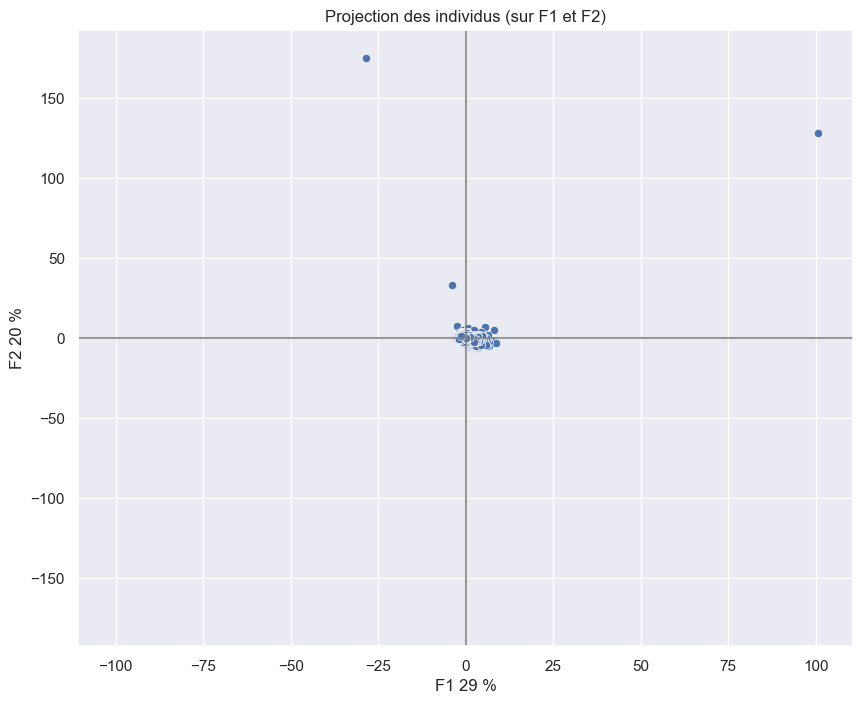

In [54]:
display_factorial_planes(result['X_proj'], (0,1), result['pca'])